In [1]:
# packages and libraries
using LinearAlgebra
lib_dir =  "/Users/scgo/Documents/Mac_Empa/my_libs/julia"
include(lib_dir*"/Imports.jl")

#=
    units:
        energy in eV
        distance in Angstrom
=#

# global parameters
t1 = 2.7
dCC = 1.42
tperp = 0.4 #[DOUBLE-CHECK VALUE]
##
hbar_vF = 3*t1*dCC/2

# Pauli matrices
sigma0 = [1 0; 0 1]
sigma1 = [0 1; 1 0]
sigma2 = [0 -im; im 0]
sigma3 = [1 0; 0 -1]

# Hamiltonian functions
#=
    AB bilayer graphene + bias + superlattice potential
    4x4 matrices
    implicit basis: layer (bottom,top), sublattice (A,B)
=#
## AB bilayer graphene (with k expanded from Dirac points)
function M_BLG_Dirac(k,Kpoint)
    kx,ky = k[1],k[2]

    Minter = tperp/2*(kron(sigma1,sigma1)-kron(sigma2,sigma2))

    if Kpoint == "K"
        Mintra = hbar_vF*(kx*kron(sigma0,sigma1) + ky*kron(sigma0,sigma2))

        return Mintra + Minter
    elseif Kpoint == "Kp"
        Mintra = hbar_vF*(-kx*kron(sigma0,sigma1) + ky*kron(sigma0,sigma2))

        return Mintra + Minter
    else
        error("Incorrect Kpoint. Must be 'K' or 'Kp'.")
    end
end
## bias
function M_bias(V0)
    return V0*kron(sigma3,sigma0)
end
## superlattice potential
function M_SL(VSL,alpha)
    return VSL/2*(kron(sigma0+sigma3,sigma0) + alpha*kron(sigma0-sigma3,sigma0))
end

# function to create vectors Qn, n=1,2,...,6
function create_Qn(L)
    Q = 2*pi/L

    Qn = [[Q*cos(2*pi*n/6),Q*sin(2*pi*n/6)] for n in 1:6]

    return Qn
end

# function to create list of non-repeated Q vectors, keeping track of indices
#=
    starts with 0, adds Qn and appends
    next iteration loops over new vectors, adds Qn and appends if not repeated
    NNorder is number of iterations

    also creates array that, for every vector, keeps track of the connected vector
=#
function create_listQ(Qn,NNorder)
    ## iteration 1
    list_Q = [[0.0,0.0]]
    list_len = [0,1]

    ## remaining iterations
    ind_nondiag = []
    for it_NNorder in 1:NNorder
        for it_Q in list_len[it_NNorder]+1:list_len[it_NNorder+1]
            Qs_it = [list_Q[it_Q]+Q for Q in Qn]

            ind_it = []
            for Q in Qs_it
                append_if_not_present!(list_Q,Q)

                ind = findfirst(vec -> isapprox(vec,Q,atol=1e-8), list_Q)
                push!(ind_it,ind)
            end
            push!(ind_nondiag,ind_it)
        end
        push!(list_len,length(list_Q))
    end

    ## additional iteration (indices only)
    for it_Q in list_len[end-1]+1:list_len[end]
        Qs_it = [list_Q[it_Q]+Q for Q in Qn]

        ind_it = []
        for Q in Qs_it
            ind = findfirst(vec -> isapprox(vec,Q,atol=1e-8), list_Q)
            if ind!=nothing
                push!(ind_it,ind)
            end
        end
        push!(ind_nondiag,ind_it)
    end

    return list_Q,ind_nondiag
end

# function to create bias Hamiltonian in continuum
function create_Hbias(V0,list_Q)
    MV0 = M_bias(V0)

    dim = 4*length(list_Q)
    Hbias = zeros(ComplexF64,dim,dim)

    for it in 1:length(list_Q)
        iti = (it-1)*4 + 1
        itf = it*4

        Hbias[iti:itf, iti:itf] += MV0
    end

    return Hbias
end

# function to create superlattice Hamiltonian in continuum
function create_HSL(VSL,alpha,ind_nondiag)
    MSL = M_SL(VSL,alpha)

    dim = 4*length(ind_nondiag)
    HSL = zeros(ComplexF64,dim,dim)

    for line in 1:length(ind_nondiag)
        linei = (line-1)*4 + 1
        linef = line*4

        for col in ind_nondiag[line]
            coli = (col-1)*4 + 1
            colf = col*4

            HSL[linei:linef, coli:colf] += MSL
        end
    end

    return HSL
end

# function to create AB bilayer graphene Hamiltonian (with k expanded from Dirac points) in continuum
function create_HBLG_Dirac(k,list_Q,Kpoint)
    dim = 4*length(list_Q)
    HBLG = zeros(ComplexF64,dim,dim)

    for it in 1:length(list_Q)
        iti = (it-1)*4 + 1
        itf = it*4

        MBLG = M_BLG_Dirac(k+list_Q[it],Kpoint)

        HBLG[iti:itf, iti:itf] += MBLG
    end

    return HBLG
end

"""
Calculates energy bands of H2D(kx,ky) (2D Bloch Hamiltonian) along kpath
"""
function En_kpath_2D(H2D,kpath;nbands=size(H2D(0,0),1))
    # energy bands
    En_kpath = Matrix{Float64}(undef,size(kpath,1),nbands)
    for itk in 1:size(kpath,1)
        kx = kpath[itk][1]
        ky = kpath[itk][2]

        H = H2D(kx,ky)

        En,_ = AuxFunctions.eigensolver_H(H,neigs=nbands)

        En_kpath[itk,:] = En
    end

    return En_kpath
end

#= ChatGPT =#

# Function to append a vector to the list if it is not already present (up to precision)
function append_if_not_present!(list_of_vectors, new_vector; atol=1e-8)
    # Check if the new vector is already in the list (up to precision atol)
    for vec in list_of_vectors
        if isapprox(vec, new_vector, atol=atol)
            return list_of_vectors # If already present, return the original list
        end
    end
    push!(list_of_vectors, new_vector) # Append the new vector if not found
    return list_of_vectors
end

# Function to calculate Euclidean distance between two points
function distance(p1, p2)
    return norm(p2 - p1)
end

# Interpolation function with proportional number of points based on distance
function interpolate_path(points; total_points=100)
    # Calculate distances between consecutive points
    distances = [distance(points[i], points[i+1]) for i in 1:length(points)-1]

    # Total distance of the path
    total_distance = sum(distances)

    # Allocate points for each segment based on its proportion of the total distance
    path = []
    for i in 1:(length(points) - 1)
        segment_distance = distances[i]
        segment_points = round(Int, total_points * (segment_distance / total_distance))

        # Interpolate points between current and next vector
        for t in 0:1/(segment_points-1):1
            push!(path, points[i] * (1 - t) + points[i + 1] * t)
        end
    end

    return path
end
;

In [11]:
# parameters
L = 500
alpha = 0.3
VSL = 0.010
V0 = 0.0
#electron density (to be done later)
NNorder = 5

# build Hamiltonian
Qn = create_Qn(L)
list_Q, ind_nondiag = create_listQ(Qn,NNorder)
Hbias = create_Hbias(V0,list_Q)
HSL = create_HSL(VSL,alpha,ind_nondiag)
HBLG_K(k) = create_HBLG_Dirac(k,list_Q,"K")
HBLG_Kp(k) = create_HBLG_Dirac(k,list_Q,"Kp")
Htot_K(kx,ky) = Hbias + HSL + HBLG_K([kx,ky])
Htot_Kp(kx,ky) = Hbias + HSL + HBLG_Kp([kx,ky])

Htot_Kp (generic function with 1 method)

364


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


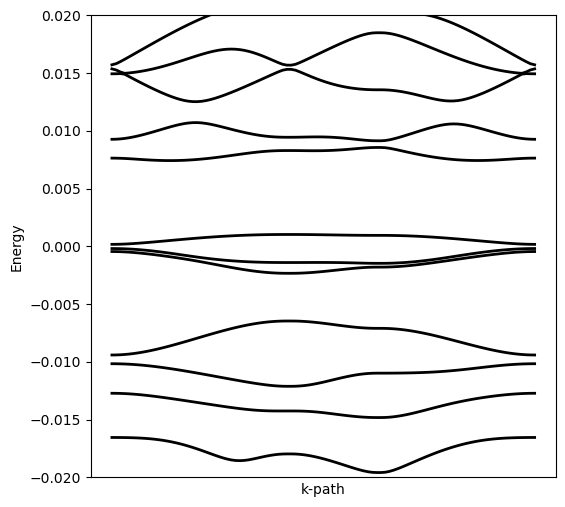

In [12]:
# plot bands in mini BZ
b1,b2 = Qn[1],Qn[2]
Gamma = [0.0,0.0]
M = Qn[1]/2
K = 1/3*(Qn[1]+Qn[2])
path_points = [Gamma, K, M, Gamma]
kpath = interpolate_path(path_points, total_points=100)
En_K_kpath = En_kpath_2D(Htot_K,kpath)
EF = (minimum(En_K_kpath[:,Int(size(En_K_kpath)[2]/2)+1]) + maximum(En_K_kpath[:,Int(size(En_K_kpath)[2]/2)]))/2
MyPyPlots.Ebands(En_K_kpath,ylims=[-0.02,0.02],EF=EF,linecolor=:black)
println(size(En_K_kpath)[2])